This notebook compares results for class imbalance using over-/undersampling and Focal Loss; also the random subsets and the "best"/"worst" subset are compared

In [1]:
#Execute once to get cifar hash lists
#!gunzip cifar10_hashsets.json.gz

In [52]:
from cifar10_trainer import train_cifar10, reduce_paths, cif_cats, cif_sets, tqdm_nb
#default parameters:
test_red = [1,2,3,4,8,12,16]
epochs_per_pass = 11
device_ids = [0,1] #experiments run on two nVidia Titan RTX w. 22GB GRAM
check_cats = ['automobile','cat'] # use cif_cats for all classes; automobile is the most stable, cat the most confused class

First test for the fall-off per category if sample size is reduced for just one class

In [59]:
strat, set0 = '_imb', 'r0'
res_under = {}
for redundancy in tqdm_nb(test_red):
    max_num = int(1000/redundancy)
    for cat in cif_cats: #use all categories here
        trgname = '%s_%s_%s%s'%(max_num,set0,cat,strat)
        if trgname in res_cat:
            continue
        max_num_all = max_num if strat == '_under' else 1000
        reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
        weights_per_class = {cat:redundancy} if strat == '_foc' else None
        tta_acc_example3_foc = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass, weights_per_class=weights_per_class, device_ids=device_ids)
        res_under[trgname] = tta_acc_example3_foc

  0%|          | 0/7 [00:00<?, ?it/s]

Summarize effect of each individual sampling strategy on class balance

In [6]:
from collections import Counter
from cifar10_trainer import reduce_paths, get_cat
def count_per_cat(cifar10_paths, idx_train=10000):
    return Counter([get_cat(p) for p in cifar10_paths[idx_train:]])

set0 = 'r0'
for strat in ['_foc','_over','_under','_imb']:
    for redundancy in test_red:
        max_num = int(1000/redundancy)
        for cat in ['automobile']: #example with one category
            max_num_all = max_num if strat == '_under' else 1000
            reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
            print(strat,redundancy,count_per_cat(reduced_subset))

_foc 1 Counter({'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000})
_foc 2 Counter({'airplane': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000, 'automobile': 500})
_foc 3 Counter({'airplane': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000, 'automobile': 333})
_foc 4 Counter({'airplane': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000, 'automobile': 250})
_foc 8 Counter({'airplane': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000, 'automobile': 125})
_foc 12 Counter({'airplane': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000, 'automobile': 83})
_fo

Check effect of each strategy on performance

In [8]:
res_sample = {}
for strat in ['_foc','_over','_under','_imb']:
    for redundancy in tqdm_nb(test_red):
        max_num = int(1000/redundancy)
        for cat in check_cats:
            trgname = '%s_%s_%s%s'%(max_num,set0,cat,strat)
            if trgname in res_cat:
                continue
            max_num_all = max_num if strat == '_under' else 1000
            reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
            weights_per_class = {cat:redundancy} if strat == '_foc' else None
            tta_acc_example3_foc = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass, weights_per_class= weights_per_class, device_ids=device_ids)
            res_sample[trgname] = tta_acc_example3_foc

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

The individual subsets ("best", "worst", 10x random) are saved to cifar10_hashsets.json (see calc_for_dict.ipynb). 

The first parameter of function reduce_paths determines which subset is used for the training run (we only compare Focal Loss here)

In [10]:
from cifar10_trainer import train_cifar10, reduce_paths, cif_cats, cif_sets, tqdm_nb

test_red = [1,2,3,4,8,12,16]
epochs_per_pass = 11
strat='_foc'
res_subset = {}
for set0 in cif_sets:
    for redundancy in tqdm_nb(test_red):
        max_num = int(1000/redundancy)
        for cat in check_cats:
            trgname = '%s_%s_%s%s'%(max_num,set0,cat,strat)
            if trgname in res_cat:
                continue
            max_num_all = max_num if strat == '_under' else 1000
            reduced_subset = reduce_paths(set0, max_num=max_num_all, per_cat={cat:max_num}, multiple_cat={cat:redundancy if strat == '_over' else 1})
            weights_per_class = {cat:redundancy} if strat == '_foc' else None
            tta_acc_example3_foc = train_cifar10(reduced_subset, verbose=False, epochs_per_pass=epochs_per_pass, weights_per_class=weights_per_class, device_ids=device_ids)
            res_subset[trgname] = tta_acc_example3_foc

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

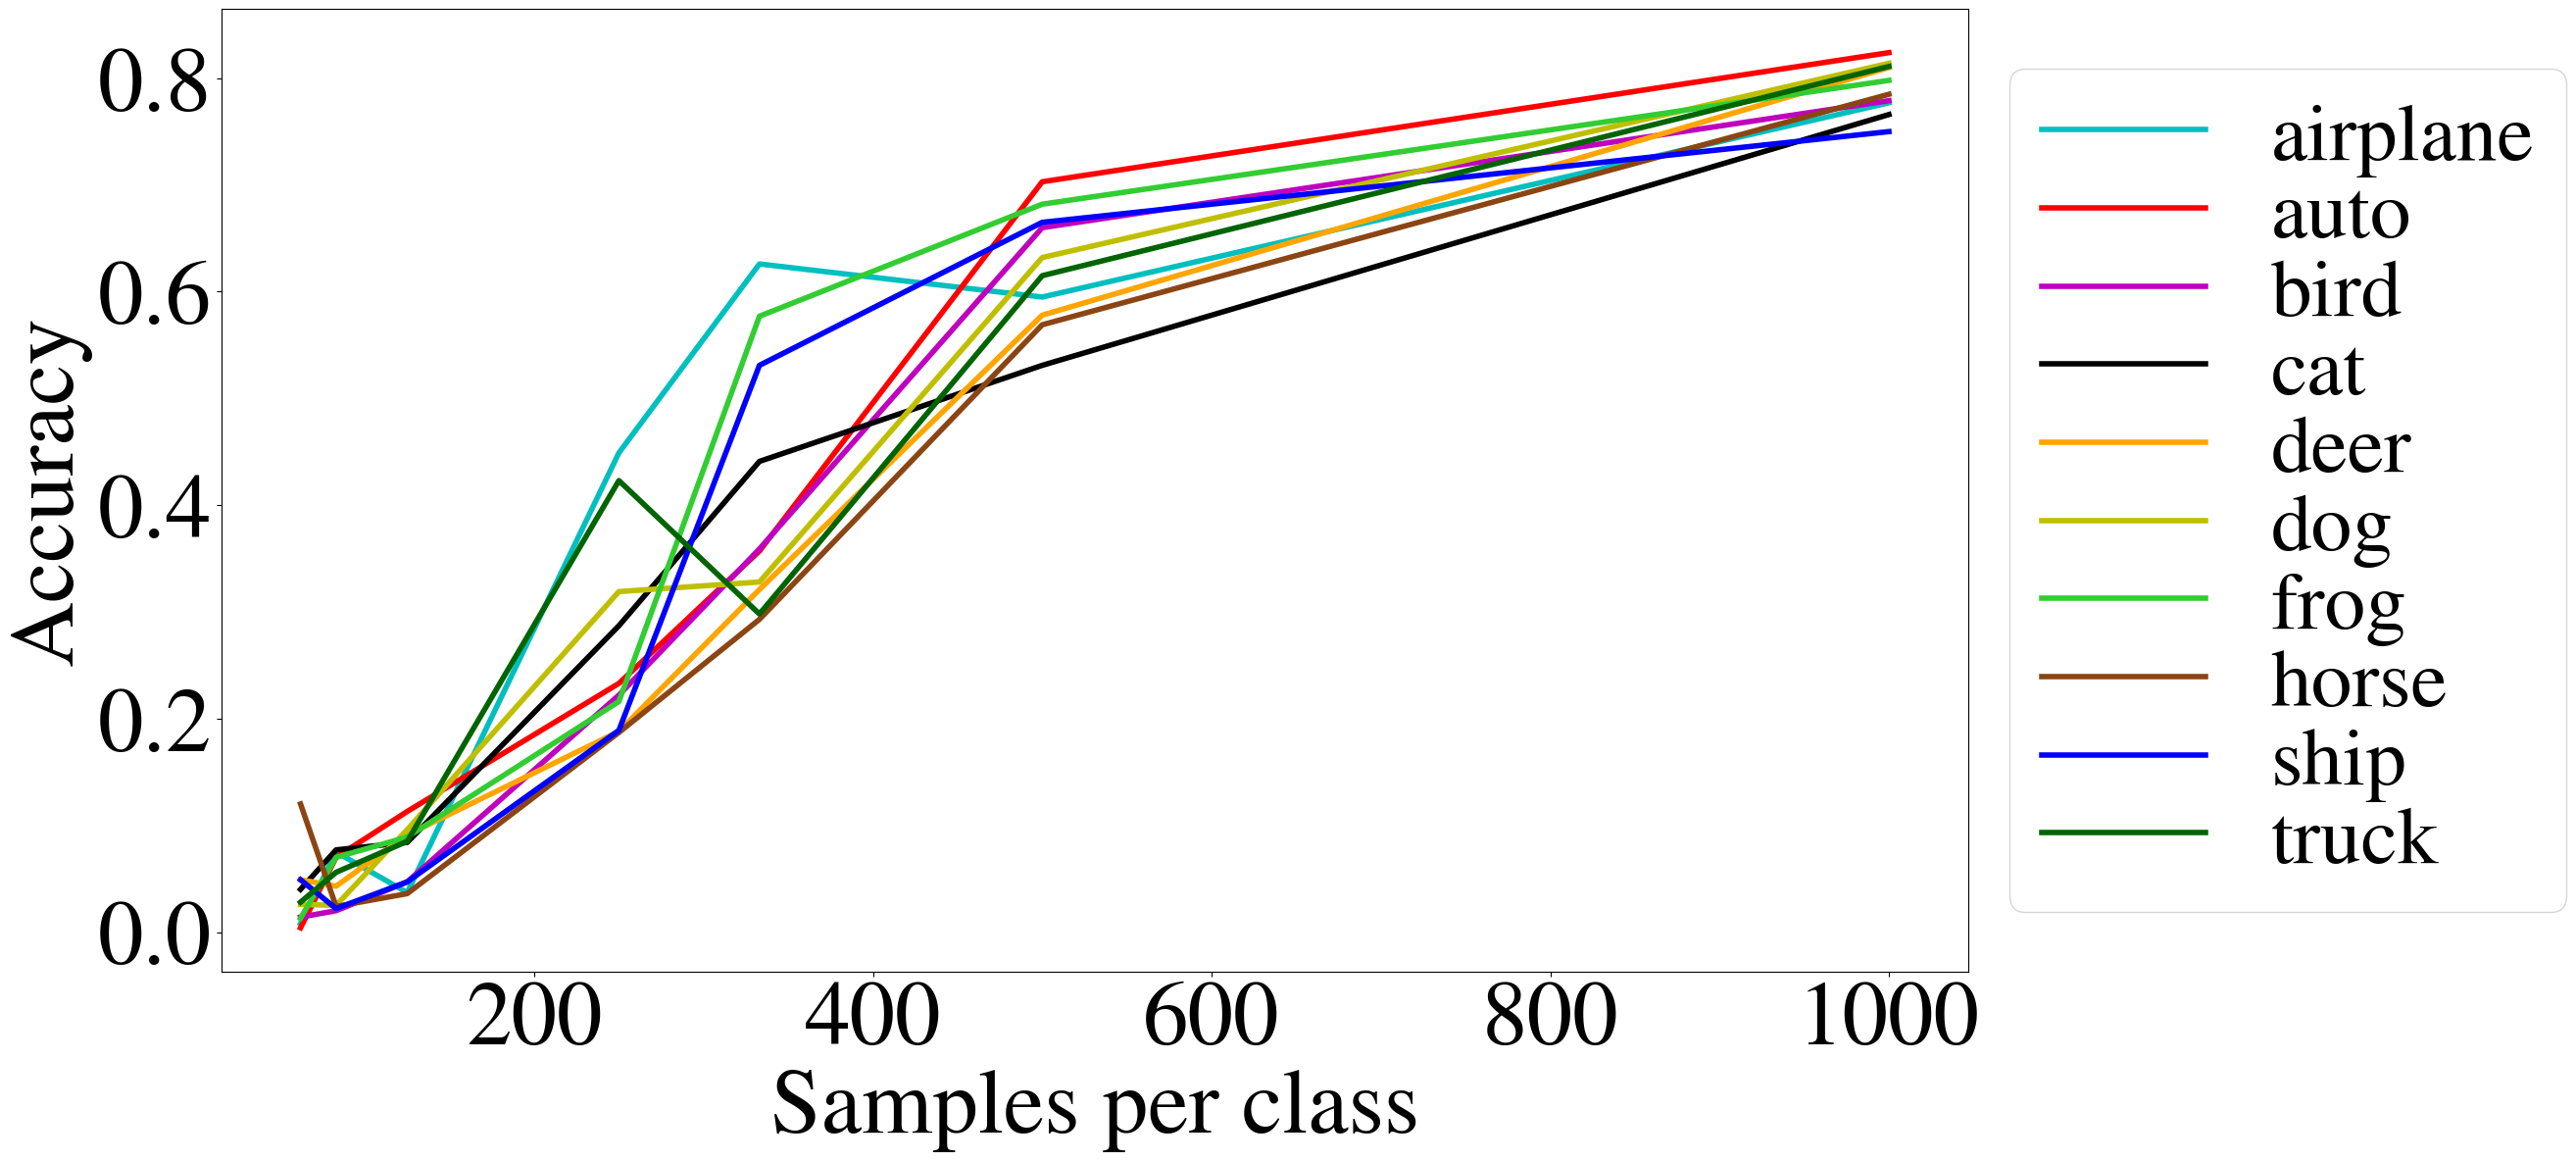

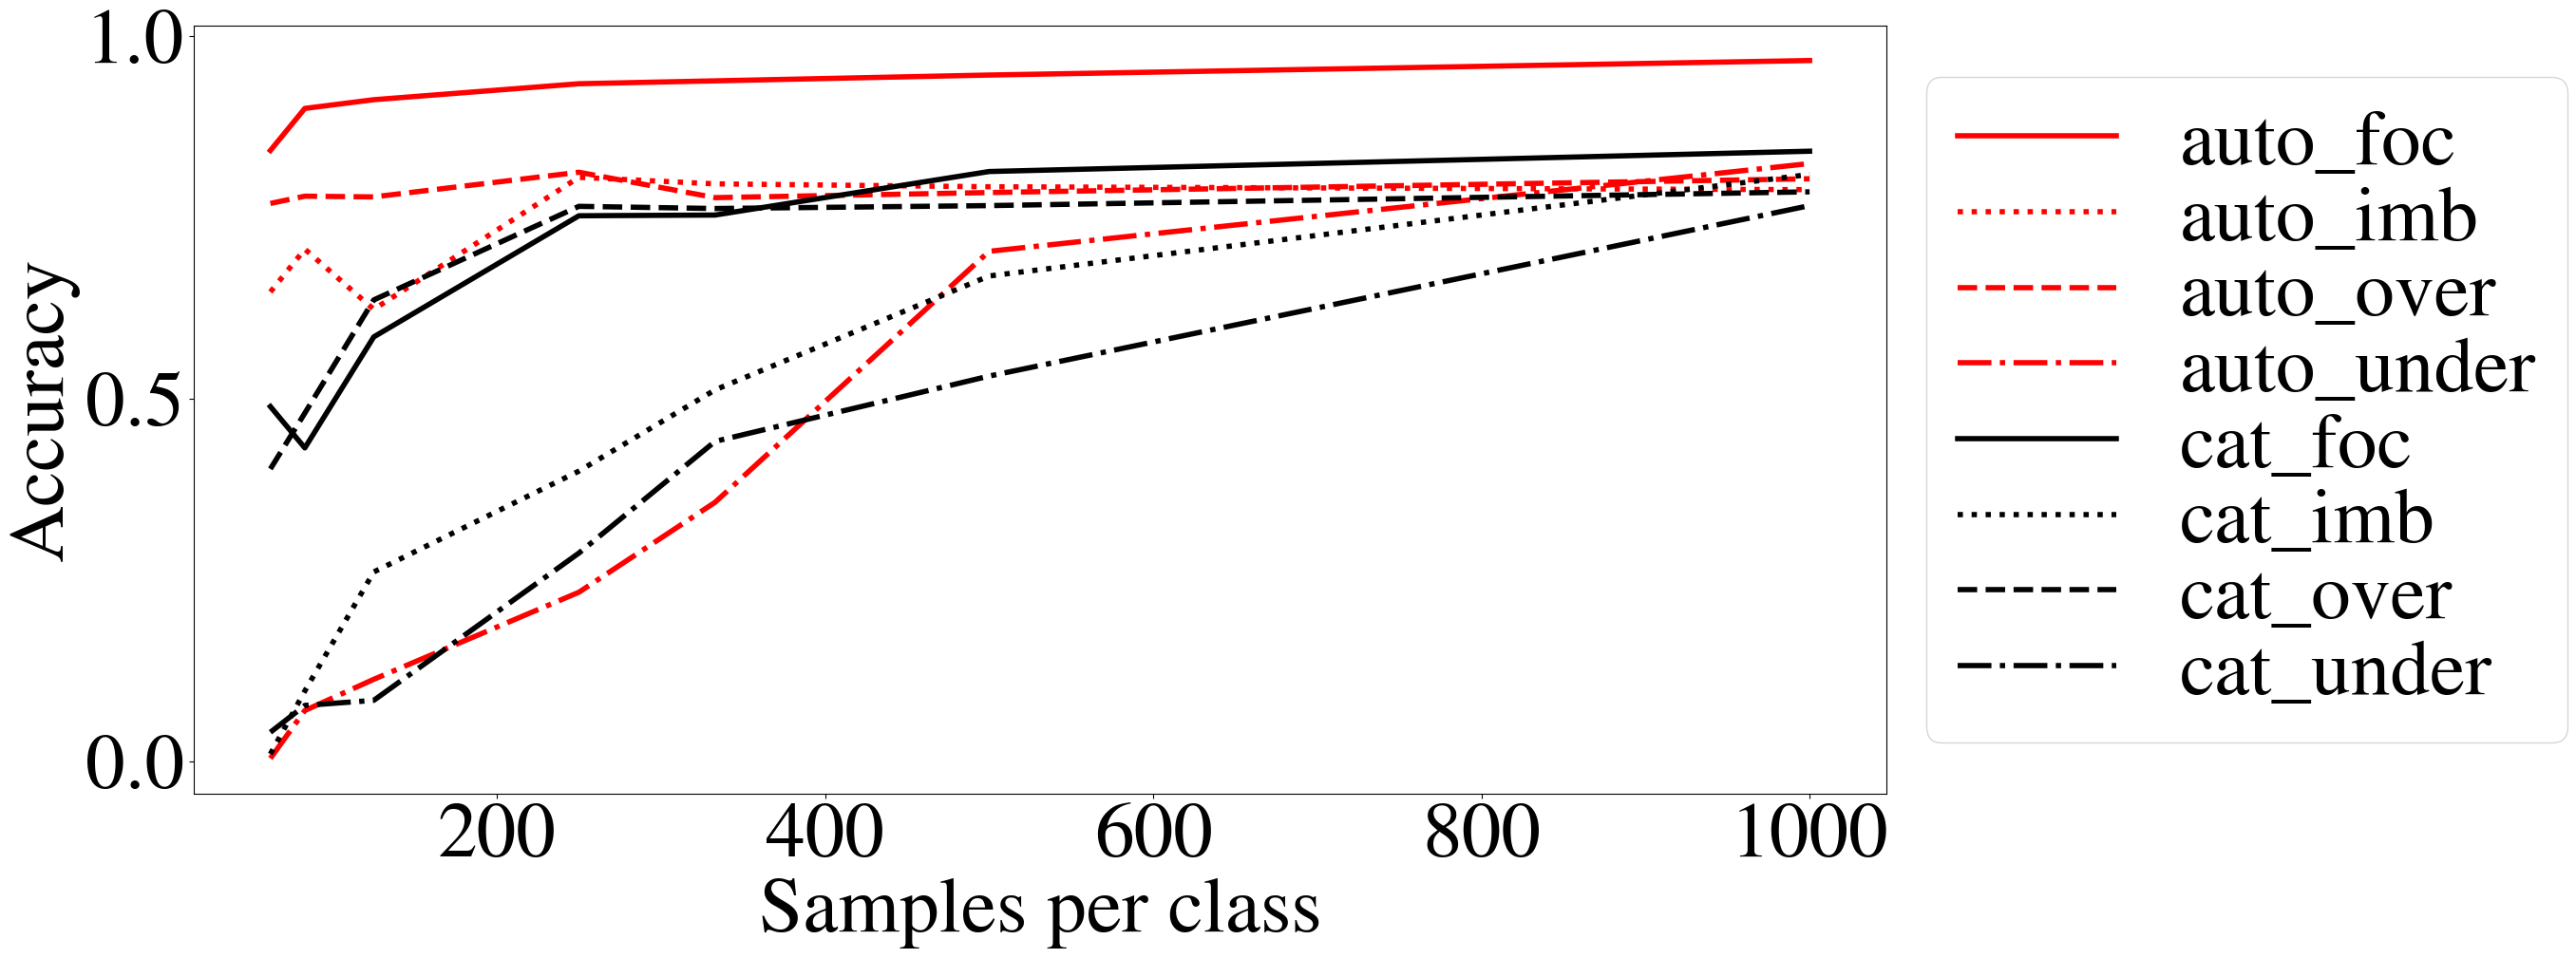

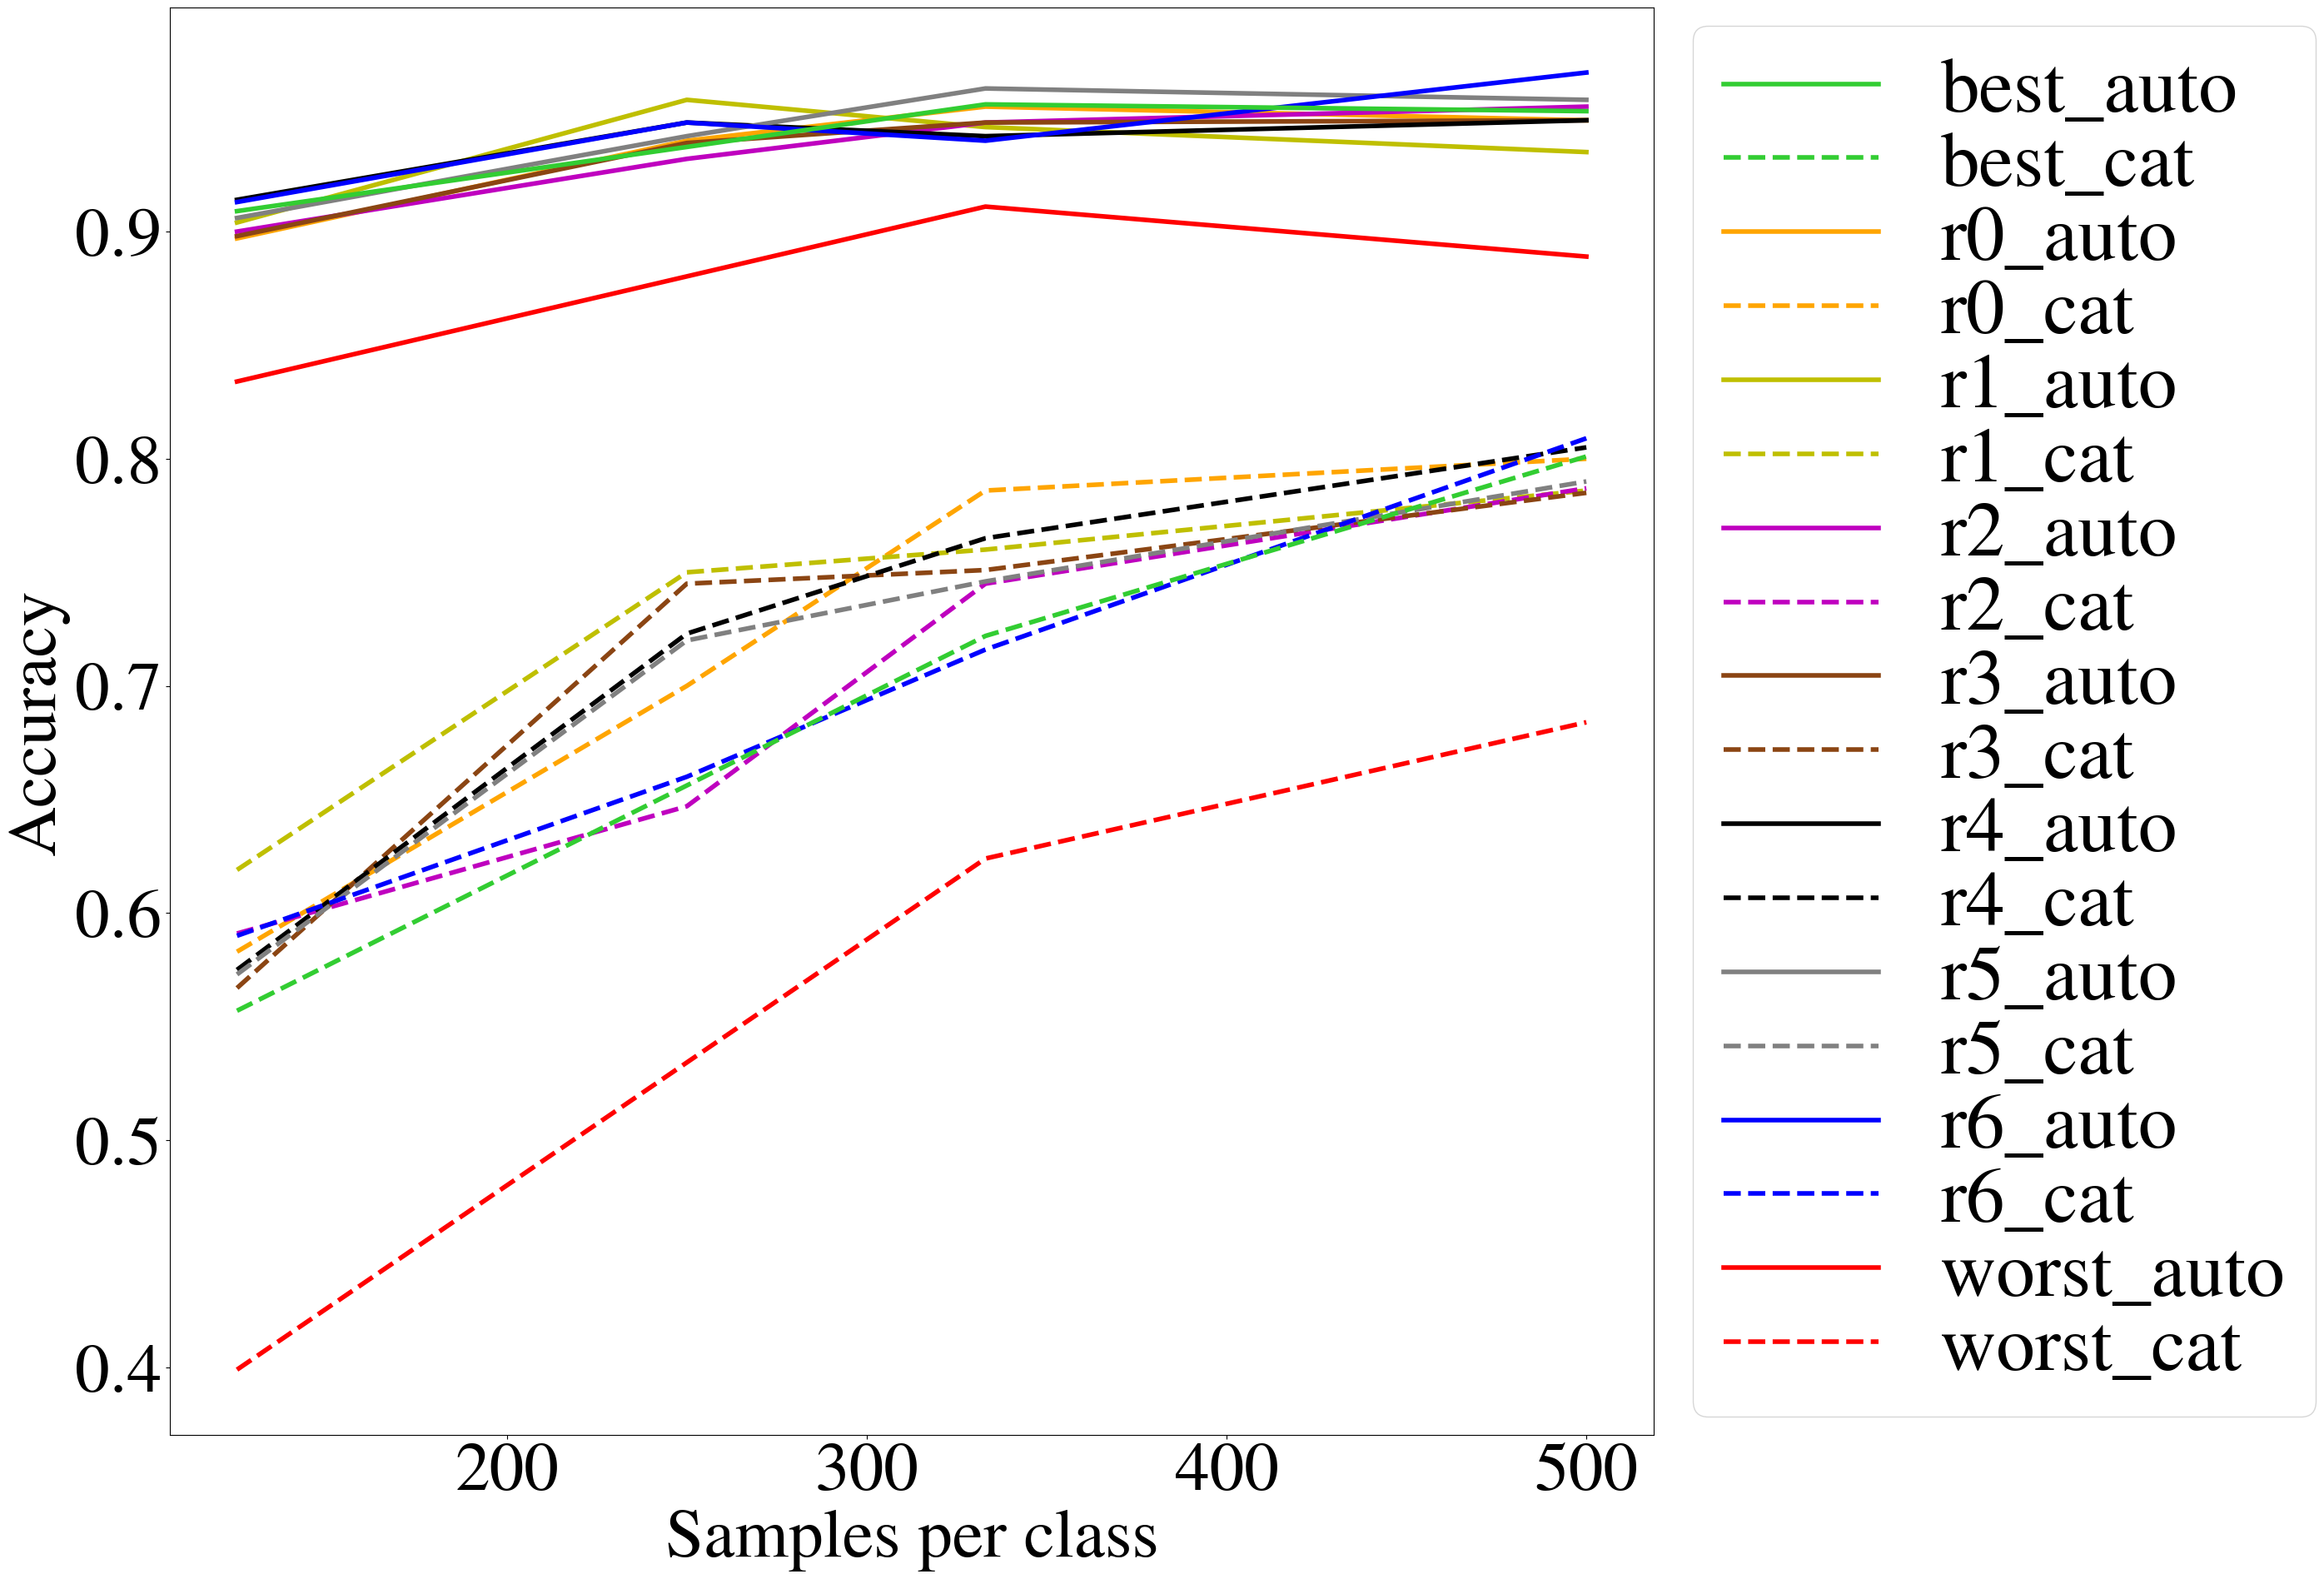

In [97]:
import matplotlib.pyplot as plt
from cifar10_trainer import cif_col, cif_cats

#custom colors for subsets
sets_col = {'worst': 'r', 'best': 'limegreen', 'r0': 'orange', 'r1': 'y', 'r2': 'm','r3': 'saddlebrown', 'r4': 'k', 'r5': 'grey','r6': 'b'}

def get_cat(s):
    return [c for c in cif_cats if c in s][0]

#plot data d with line width line_w using visualisation version figversion
# v0: categories
# v1: sampling strategies
# v2: subsets
def plot_dict(figdata, line_w, figversion):
    col_map = sets_col if figversion == 2 else cif_col
    val_sets_x, val_sets_y = {}, {}
    for k,y in figdata.items():
        if isinstance(y,dict): #only include affected category
            y = y[k.split('_')[-2]]
        x = k.split('_')[0]
        n = k.replace(x+'_','')
        val_sets_x.setdefault(n,[]).append(int(x))
        val_sets_y.setdefault(n,[]).append(y)
    sorted_keys = sorted(val_sets_y.keys())
    for k in sorted_keys:
        idxset = 0 if figversion == 2 else -2
        set0 = k.split('_')[idxset].lower()
        if not set0 in col_map:
            continue
        v = val_sets_y[k]
        ord0 = list(sorted(range(len(val_sets_x[k])), key=lambda d: val_sets_x[k][d]))
        xv = [val_sets_x[k][i] for i in ord0]
        yv = [v[i] for i in ord0]

        if figversion == 1:
            ls=':' if '_imb' in k else ('--' if '_over' in k else ('-' if 'foc' in k else '-.'))
        else:
            ls= '--' if figversion > 0 and '_cat' in k else '-'
        lab0 = k.replace('automobile', 'auto')
        if figversion != 1:
            lab0 = lab0.replace('_foc','').replace('_imb','').replace('_under','')
        if figversion != 2:
            lab0 = lab0.replace('r0_','')
        if set0 == 'best':
            plt.plot(xv, yv, color=col_map[set0], label = lab0, linestyle=ls, linewidth=line_w, zorder=1000)
        else:
            plt.plot(xv, yv, color=col_map[set0], label = lab0, linestyle=ls, linewidth=line_w)
            
def plot_figs():
    figname = ['fig_under','fig_cmp', 'fig_worst_subset']
    fontsz = ['60','60','67']
    plt_height = [12.75,10.5,22.25]
    for figversion, figdata in enumerate([res_under,res_sample,res_subset]):
        plt.close()
        plt.subplots(figsize=(23, plt_height[figversion]))
        plt.rcParams['font.size'] = fontsz[figversion]
        plt.rcParams['mathtext.fontset'] = 'stix'
        plt.rcParams['font.family'] = 'STIXGeneral'
        plot_dict(figdata, line_w=4, figversion=figversion)
        plt.legend(labelspacing=0.04, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("Samples per class")
        plt.ylabel("Accuracy")
        plt.savefig(figname[figversion]+'_graph.png', bbox_inches = "tight")
        plt.show()
        
plot_figs()